In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session


# credit: https://gist.github.com/soply/f3eec2e79c165e39c9d540e916142ae1
import matplotlib.pyplot as plt
import numpy as np

def show_images(images, cols = 1, titles = None):
    """Display a list of images in a single figure with matplotlib.
    
    Parameters
    ---------
    images: List of np.arrays compatible with plt.imshow.
    
    cols (Default = 1): Number of columns in figure (number of rows is 
                        set to np.ceil(n_images/float(cols))).
    
    titles: List of titles corresponding to each image. Must have
            the same length as titles.
    """
    assert((titles is None)or (len(images) == len(titles)))
    n_images = len(images)
    if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
    fig = plt.figure()
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)
        if image.ndim == 2:
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    plt.show()

In [2]:
train_df = pd.read_csv("../input/global-wheat-detection/train.csv")

In [3]:
# 147,793 training bounding boxes, on 3,373 images
train_df.shape, len(train_df.image_id.unique())
print("There are {} unique bounding boxes on {} unique training images (with boxes) from {} different sources. ".format(train_df.shape[0], len(train_df.image_id.unique()),len(train_df.source.unique()) ))

There are 147793 unique bounding boxes on 3373 unique training images (with boxes) from 7 different sources. 


* The train set contains 3422 images, so that means there are 49 images in the set that contain 0 bounding boxes.

In [4]:
# Shape of training images
train_df.height.unique(), train_df.width.unique()
# All images are the same width and height, and more importanntly square which could help with certain object detector types

(array([1024]), array([1024]))

#### Regions

In [5]:
#Distribution of source images is somewhat skewed, lets see if there are any visual differences by region
#(or if the average size of the bounding box varies by region)
train_df[["image_id", "source"]].groupby("source").count().sort_values("image_id", ascending = False).reset_index()

source  image_id
0     ethz_1     51489
1  arvalis_1     45716
2     rres_1     20236
3  arvalis_3     16665
4    usask_1      5807
5  arvalis_2      4179
6    inrae_1      3701

* Keep this in mind for when you start to look for patterns in detection accuracy or mAP by source as some regions are under represented in teh train set.  


The image with the most bboxes has 116 and the one with the least (besides the ones with zero) has 1


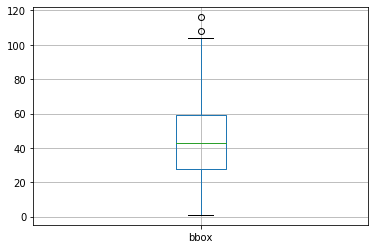

In [6]:
### How many bounding boxes do images have?
df_by_id = train_df[["image_id","bbox"]].groupby("image_id").count().reset_index()
boxplot = df_by_id.boxplot(column=['bbox'])
print("The image with the most bboxes has {} and the one with the least (besides the ones with zero) has {}".format(df_by_id.bbox.max(), df_by_id.bbox.min()))

* Median number of bounding boxes in each image seems to be around 42. Let's keep this is mind in case your detector uses anchors and there might be a need to recalculate anchors that are smaller than perhaps ImageNet (if you plan on using pre trained weights)

* There are **49 images in the train set without bounding boxes.**

* Keep in mind some detectors are better/worse for small objects and some detectors might have performance issues around grid if they use a grid at the detection stage. 

In [7]:
import random
from matplotlib import image

### Checking some images from different sources:

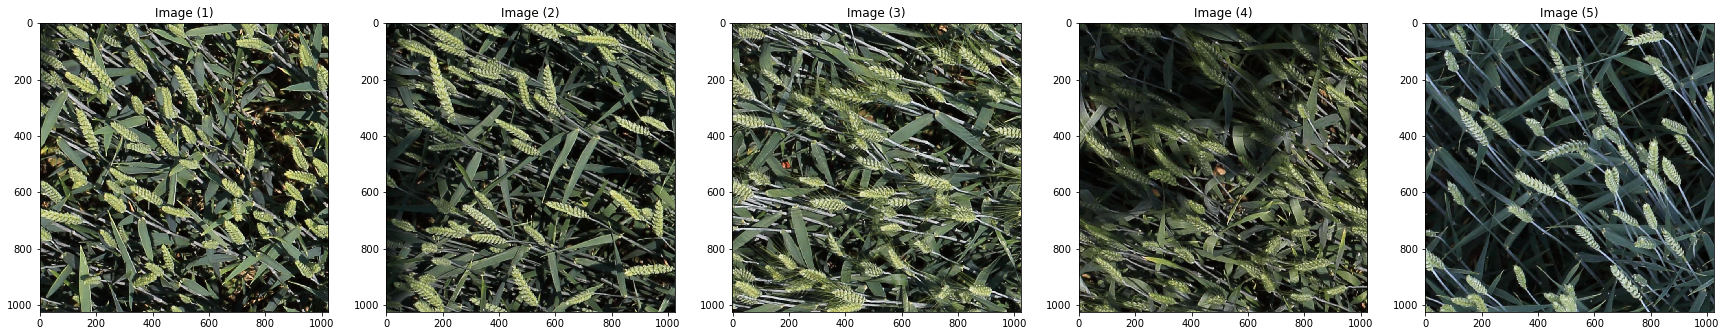

In [8]:
img_subset = train_df[train_df["source"]=="ethz_1"]
img_subset_imageids = img_subset.image_id.unique()
random.shuffle(img_subset_imageids)
rs = ["../input/global-wheat-detection/train/{}.jpg".format(i) for i in img_subset_imageids[:5]]

image_list = []
for i in rs:
    img = image.imread(i)
    image_list.append(img)
    
show_images(image_list)

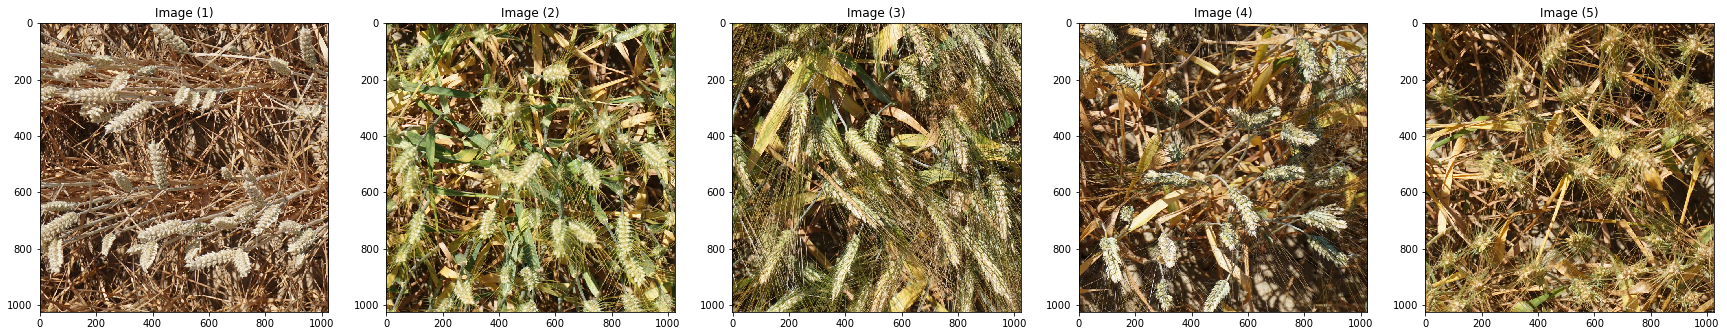

In [9]:
img_subset = train_df[train_df["source"]=="arvalis_1"]
img_subset_imageids = img_subset.image_id.unique()
random.shuffle(img_subset_imageids)
rs = ["../input/global-wheat-detection/train/{}.jpg".format(i) for i in img_subset_imageids[:5]]

image_list = []
for i in rs:
    img = image.imread(i)
    image_list.append(img)
    
show_images(image_list)

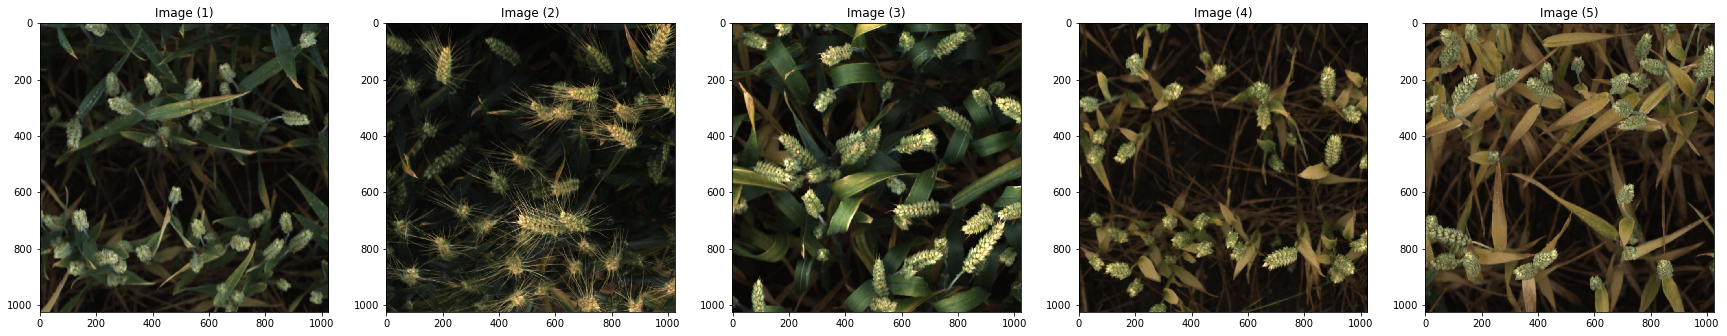

In [10]:
img_subset = train_df[train_df["source"]=="rres_1"]
img_subset_imageids = img_subset.image_id.unique()
random.shuffle(img_subset_imageids)
rs = ["../input/global-wheat-detection/train/{}.jpg".format(i) for i in img_subset_imageids[:5]]

image_list = []
for i in rs:
    img = image.imread(i)
    image_list.append(img)
    
show_images(image_list)

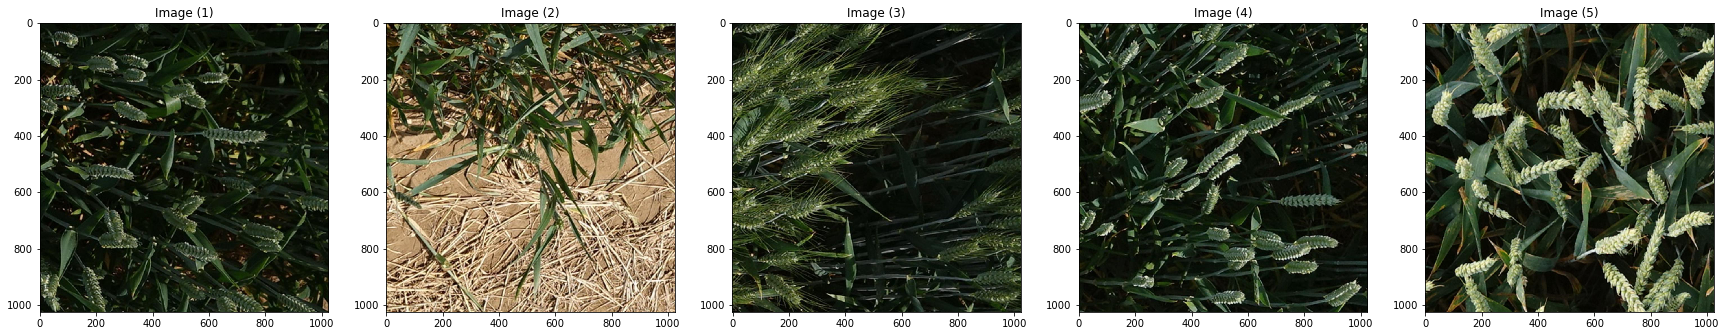

In [11]:
img_subset = train_df[train_df["source"]=="arvalis_3"]
img_subset_imageids = img_subset.image_id.unique()
random.shuffle(img_subset_imageids)
rs = ["../input/global-wheat-detection/train/{}.jpg".format(i) for i in img_subset_imageids[:5]]

image_list = []
for i in rs:
    img = image.imread(i)
    image_list.append(img)
    
show_images(image_list)

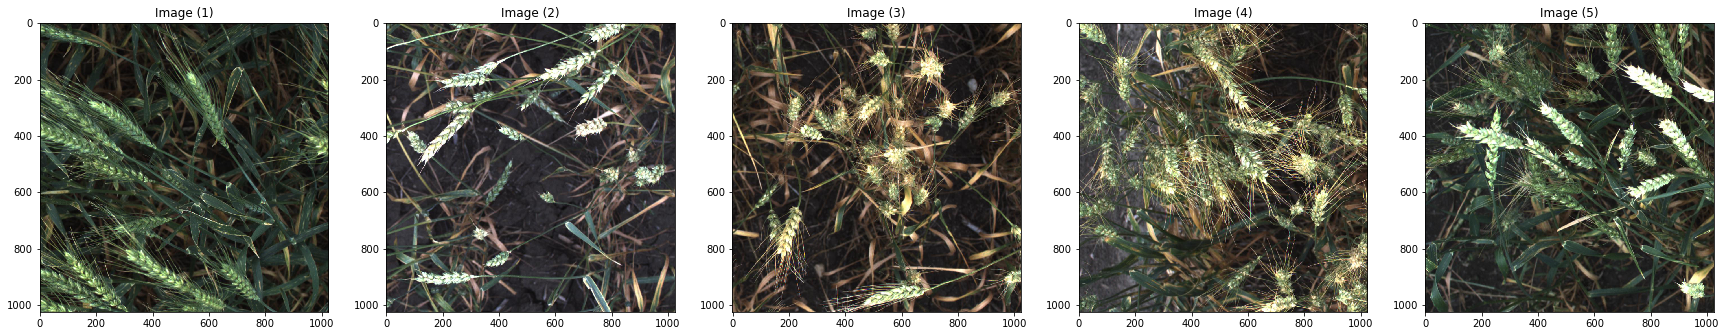

In [12]:
img_subset = train_df[train_df["source"]=="usask_1"]
img_subset_imageids = img_subset.image_id.unique()
random.shuffle(img_subset_imageids)
rs = ["../input/global-wheat-detection/train/{}.jpg".format(i) for i in img_subset_imageids[:5]]

image_list = []
for i in rs:
    img = image.imread(i)
    image_list.append(img)
    
show_images(image_list)

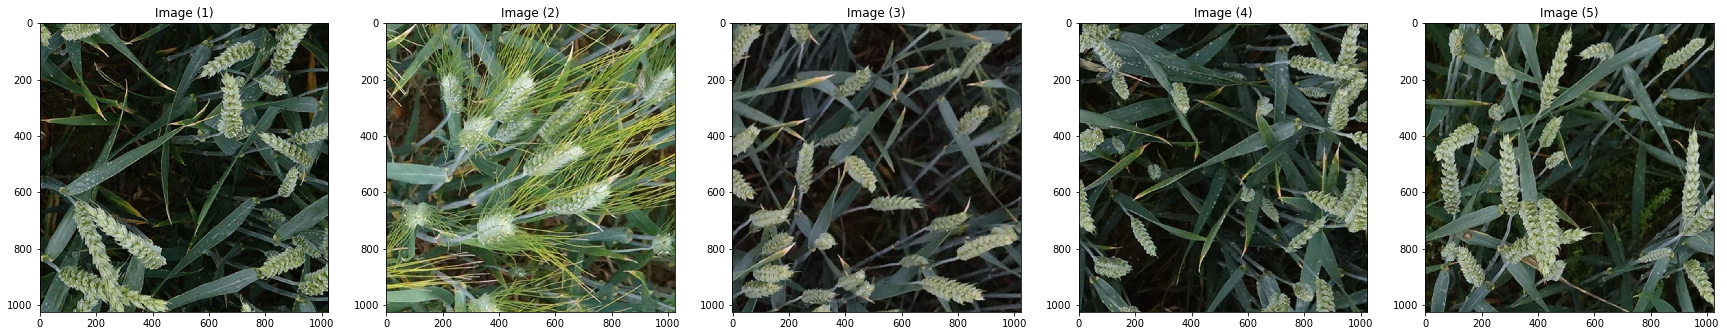

In [13]:
img_subset = train_df[train_df["source"]=="inrae_1"]
img_subset_imageids = img_subset.image_id.unique()
random.shuffle(img_subset_imageids)
rs = ["../input/global-wheat-detection/train/{}.jpg".format(i) for i in img_subset_imageids[:5]]

image_list = []
for i in rs:
    img = image.imread(i)
    image_list.append(img)
    
show_images(image_list)